In [2]:
# Disable warinings
#import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'; os.environ['KMP_DUPLICATE_LIB_OK']='True' 

#DNN library
import tensorflow as tf
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout

#common library
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rc('image', cmap='copper') #global colormap 

#random seed
seed=2086516
np.random.seed(seed) # fix random seed

%run nonlinear_function.py #here is loaded the filename, run one i belive

#training percentage
perc_train = 0.8

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 1.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 1.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 1.0
[14.24753279 21.74536208] 0.0
data: 4000
train: 3200


<function matplotlib.pyplot.show(close=None, block=None)>

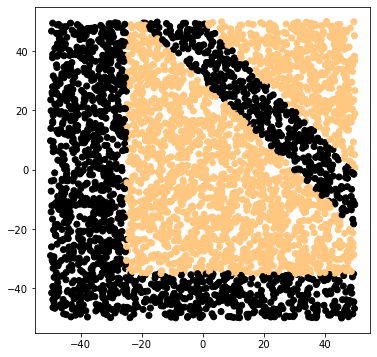

In [4]:
# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (6,6))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show

In [5]:
### Split training and test data

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


In [6]:
### Rescale input data

def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50 #the number goes from -50 to 50, so we put them between -1 and 1 to use the non linearity 

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

### Define the model with Keras / Tensorflow

In [28]:
def create_DNN(act_func, neurons): 
    CASE=1
    
    if CASE==1:
        model = Sequential() #empty template of the neural network
        model.add(Dense(L,input_shape=(L,),activation=act_func)) #add a layer dense (all connection) with a ReLu 2 neuron for 2 x_i
        model.add(Dense(units=neurons,activation=act_func))
        model.add(Dense(units=neurons,activation=act_func))
        model.add(Dense(units=neurons,activation=act_func))
        model.add(Dropout(0.2)) #it is applied to the last layer, need to be reader in keras documentation 
        model.add(Dense(1,activation='sigmoid'))
        nepoch=400
    # as case 1 but one layer shorter
    if CASE==2:
        model = Sequential()
        model.add(Dense(L,input_shape=(L,),activation=act_func))
        model.add(Dense(units=neurons,activation=act_func))
        model.add(Dense(units=neurons,activation=act_func))
        model.add(Dropout(0.2))
        model.add(Dense(1,activation='sigmoid'))
        nepoch=400
    
    return model 

### Optimization method and cost function

In [29]:
def compile_model(optimizer='adam', act_func='relu', neurons=20):
    model = create_DNN(act_func, neurons)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

### Training

## EX.1 Modify the Hyperparameters to Optimize Performance of the Mode

In [30]:
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

#batch_size=50

In [31]:
# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Adamax']
act_func = ['sigmoid','tanh', 'ReLU', 'ELU']
batch_size = [10, 20, 30]
nepochs = 8
neurons =[10, 20, 30]


# call Keras scikit wrapper
model_gridsearch = KerasClassifier(model=compile_model, 
                        epochs=nepochs, 
                        batch_size=batch_size, 
                        verbose=1,
                        act_func=act_func,
                        model__neurons=neurons)

# define parameter dictionary
param_grid = dict(optimizer=optimizer, act_func=act_func, batch_size=batch_size, model__neurons=neurons)
print(param_grid)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Adamax'], 'act_func': ['sigmoid', 'tanh', 'ReLU', 'ELU'], 'batch_size': [10, 20, 30], 'model__neurons': [10, 20, 30]}
Epoch 1/8
320/320 [==============================] - 1s 2ms/step - loss: 0.6507 - accuracy: 0.6128
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 0.5308 - accuracy: 0.7734
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 0.4085 - accuracy: 0.8384
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 0.3652 - accuracy: 0.8575
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 0.3409 - accuracy: 0.8619
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 0.3221 - accuracy: 0.8644
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 0.3122 - accuracy: 0.8625
Epoch 8/8
320/320 [==============================] - 1s 2ms/step - loss: 0.2971 - accuracy: 0.8656
Best: 0.856250 using {'act_func': 'Re

In [32]:
grid_result.best_params_, grid_result.best_score_

({'act_func': 'ReLU',
  'batch_size': 10,
  'model__neurons': 30,
  'optimizer': 'RMSprop'},
 0.85625)

## Ex.2 Change the number of sample 

### Reduced number of sample

In [35]:
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')

red_val=0.6
(x, y) = (x[:int(red_val*len(x))], y[:int(red_val*len(x))])

N=len(x)
perc_train=0.8
N_train = int(N*perc_train)

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1920 	 Validation: 480


In [36]:
#optimization
nepochs=400



model_reduced = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'], neurons=grid_result.best_params_['model__neurons'])

In [37]:
history_reduced = model_reduced.fit(x_train, y_train,
               epochs = nepochs, batch_size = grid_result.best_params_['batch_size'],
               validation_data=(x_valid,y_valid),
               verbose=2)

Epoch 1/400
192/192 - 2s - loss: 0.7300 - accuracy: 0.6078 - val_loss: 0.6552 - val_accuracy: 0.6229 - 2s/epoch - 8ms/step
Epoch 2/400
192/192 - 0s - loss: 0.6527 - accuracy: 0.6406 - val_loss: 0.6290 - val_accuracy: 0.6896 - 402ms/epoch - 2ms/step
Epoch 3/400
192/192 - 0s - loss: 0.6320 - accuracy: 0.6672 - val_loss: 0.6107 - val_accuracy: 0.6854 - 413ms/epoch - 2ms/step
Epoch 4/400
192/192 - 0s - loss: 0.6263 - accuracy: 0.6625 - val_loss: 0.6070 - val_accuracy: 0.6875 - 374ms/epoch - 2ms/step
Epoch 5/400
192/192 - 0s - loss: 0.6162 - accuracy: 0.6802 - val_loss: 0.6137 - val_accuracy: 0.6667 - 370ms/epoch - 2ms/step
Epoch 6/400
192/192 - 0s - loss: 0.6118 - accuracy: 0.6917 - val_loss: 0.6189 - val_accuracy: 0.6667 - 401ms/epoch - 2ms/step
Epoch 7/400
192/192 - 0s - loss: 0.6080 - accuracy: 0.6922 - val_loss: 0.5999 - val_accuracy: 0.6875 - 425ms/epoch - 2ms/step
Epoch 8/400
192/192 - 0s - loss: 0.6044 - accuracy: 0.6948 - val_loss: 0.6061 - val_accuracy: 0.6750 - 388ms/epoch - 2ms/

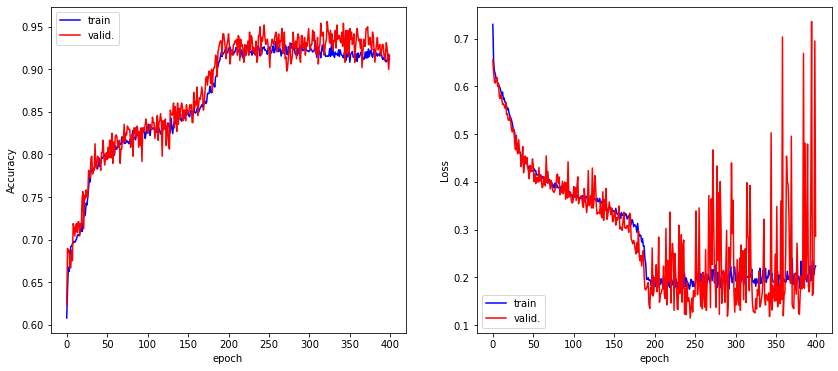

In [39]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history_reduced.history['accuracy'],label="train",c="b")
ax.plot(history_reduced.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history_reduced.history['loss'],label="train",c="b")
ax.plot(history_reduced.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [55]:
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')

x_aug = x + np.random.normal(0, 0.05, size=x.shape)
y_aug = np.copy(y)

xT = np.vstack((x, x_aug))
yT = np.hstack((y, y_aug))

N=len(xT)
perc_train=0.8
N_train = int(N*perc_train)


(x_train, y_train) = (xT[0:N_train],yT[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (xT[N_train:],yT[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 6400 	 Validation: 1600


In [56]:
print(xT.shape, yT.shape)

(8000, 2) (8000,)


In [57]:
#optimization
nepochs=400



model_reduced = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'], neurons=grid_result.best_params_['model__neurons'])

In [58]:
history_reduced = model_reduced.fit(x_train, y_train,
               epochs = nepochs, batch_size = grid_result.best_params_['batch_size'],
               validation_data=(x_valid,y_valid),
               verbose=2)

Epoch 1/400
640/640 - 3s - loss: 0.6137 - accuracy: 0.6598 - val_loss: 0.5410 - val_accuracy: 0.7038 - 3s/epoch - 4ms/step
Epoch 2/400
640/640 - 1s - loss: 0.5253 - accuracy: 0.7289 - val_loss: 0.4514 - val_accuracy: 0.7831 - 1s/epoch - 2ms/step
Epoch 3/400
640/640 - 1s - loss: 0.4549 - accuracy: 0.7809 - val_loss: 0.4220 - val_accuracy: 0.7881 - 1s/epoch - 2ms/step
Epoch 4/400
640/640 - 1s - loss: 0.4303 - accuracy: 0.7898 - val_loss: 0.4180 - val_accuracy: 0.7994 - 1s/epoch - 2ms/step
Epoch 5/400
640/640 - 1s - loss: 0.4163 - accuracy: 0.7998 - val_loss: 0.4003 - val_accuracy: 0.7994 - 1s/epoch - 2ms/step
Epoch 6/400
640/640 - 1s - loss: 0.4107 - accuracy: 0.8014 - val_loss: 0.3926 - val_accuracy: 0.8075 - 1s/epoch - 2ms/step
Epoch 7/400
640/640 - 1s - loss: 0.4049 - accuracy: 0.8036 - val_loss: 0.4090 - val_accuracy: 0.7987 - 1s/epoch - 2ms/step
Epoch 8/400
640/640 - 1s - loss: 0.4028 - accuracy: 0.8025 - val_loss: 0.3931 - val_accuracy: 0.8031 - 1s/epoch - 2ms/step
Epoch 9/400
640/

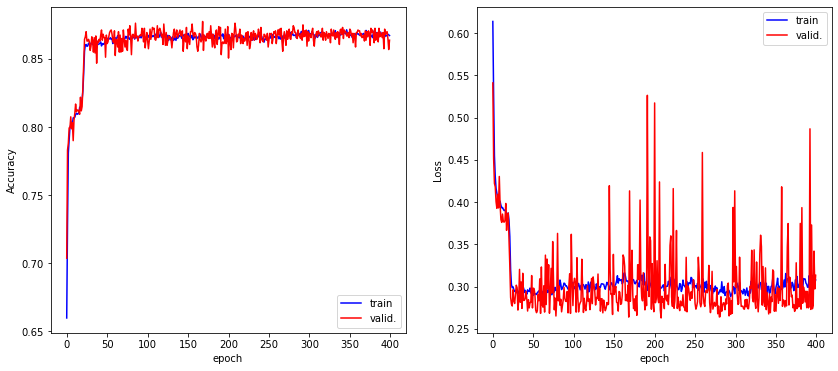

In [59]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history_reduced.history['accuracy'],label="train",c="b")
ax.plot(history_reduced.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history_reduced.history['loss'],label="train",c="b")
ax.plot(history_reduced.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()